In [44]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

import matplotlib.pyplot as plt
%matplotlib inline

In [45]:
#create Spark session
spark = SparkSession.builder.appName('Project').getOrCreate()

#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '5g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','8g')])

# Setup some initial options before you start running the notebook

USE_SUBSET = False

In [46]:
econ_data = spark.read.csv("gs://msca-bdp-student-gcs/chicago-economic-data/Census_Data_-_Selected_socioeconomic_indicators_in_Chicago__2008___2012.csv", header = True)
taxi_data = spark.read.parquet("gs://msca-bdp-student-gcs/chicago-taxi-trips-data/*.parquet",inferSchema=True)


df_pickup = taxi_data.join(
    econ_data,
    taxi_data.pickup_community_area == econ_data['Community Area Number'],
    'left'
).select(
    taxi_data["*"],
    *[econ_data[c].alias("pickup_" + c) for c in econ_data.columns if c != 'Community Area Number']
)

df = df_pickup.join(
    econ_data,
    df_pickup.dropoff_community_area == econ_data['Community Area Number'],
    'left'
).select(
    df_pickup["*"],
    *[econ_data[c].alias("dropoff_" + c) for c in econ_data.columns if c != 'Community Area Number']
)

if USE_SUBSET:
    df = df.sample(False,.1)
else:
    pass

14805983708  gs://msca-bdp-student-gcs/chicago-taxi-trips-data/*.parquet

This command and the corresponding result were created in the GCS console. This indicates that the size of our primary dataset is around 13.8GB

In [47]:
df.show(1)

+--------------------+--------------------+--------------------+-------------------+------------+----------+-------------------+--------------------+---------------------+----------------------+----+----+-----+------+----------+------------+--------------------+---------------+----------------+---------------+----------------+-----------------+----------------+--------------------------+---------------------------------+---------------------------------------+----------------------------------+---------------------------------------------------+---------------------------------------+-------------------------+---------------------+---------------------------+----------------------------------+----------------------------------------+-----------------------------------+----------------------------------------------------+----------------------------------------+--------------------------+----------------------+
|          unique_key|             taxi_id|trip_start_timestamp| trip_end_ti

In [48]:
df.columns

['unique_key',
 'taxi_id',
 'trip_start_timestamp',
 'trip_end_timestamp',
 'trip_seconds',
 'trip_miles',
 'pickup_census_tract',
 'dropoff_census_tract',
 'pickup_community_area',
 'dropoff_community_area',
 'fare',
 'tips',
 'tolls',
 'extras',
 'trip_total',
 'payment_type',
 'company',
 'pickup_latitude',
 'pickup_longitude',
 'pickup_location',
 'dropoff_latitude',
 'dropoff_longitude',
 'dropoff_location',
 'pickup_COMMUNITY AREA NAME',
 'pickup_PERCENT OF HOUSING CROWDED',
 'pickup_PERCENT HOUSEHOLDS BELOW POVERTY',
 'pickup_PERCENT AGED 16+ UNEMPLOYED',
 'pickup_PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA',
 'pickup_PERCENT AGED UNDER 18 OR OVER 64',
 'pickup_PER CAPITA INCOME ',
 'pickup_HARDSHIP INDEX',
 'dropoff_COMMUNITY AREA NAME',
 'dropoff_PERCENT OF HOUSING CROWDED',
 'dropoff_PERCENT HOUSEHOLDS BELOW POVERTY',
 'dropoff_PERCENT AGED 16+ UNEMPLOYED',
 'dropoff_PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA',
 'dropoff_PERCENT AGED UNDER 18 OR OVER 64',
 'dropoff_PER CAP

In [49]:
df.printSchema()

root
 |-- unique_key: string (nullable = true)
 |-- taxi_id: string (nullable = true)
 |-- trip_start_timestamp: timestamp (nullable = true)
 |-- trip_end_timestamp: timestamp (nullable = true)
 |-- trip_seconds: long (nullable = true)
 |-- trip_miles: double (nullable = true)
 |-- pickup_census_tract: long (nullable = true)
 |-- dropoff_census_tract: long (nullable = true)
 |-- pickup_community_area: long (nullable = true)
 |-- dropoff_community_area: long (nullable = true)
 |-- fare: double (nullable = true)
 |-- tips: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- extras: double (nullable = true)
 |-- trip_total: double (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- company: string (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_location: string (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- drop

In [51]:
df.describe().show()

+-------+--------------------+--------------------+------------------+------------------+--------------------+--------------------+---------------------+----------------------+------------------+------------------+--------------------+------------------+------------------+------------+--------------------+-------------------+-------------------+--------------------+-----------------+--------------------+--------------------+--------------------------+---------------------------------+---------------------------------------+----------------------------------+---------------------------------------------------+---------------------------------------+-------------------------+---------------------+---------------------------+----------------------------------+----------------------------------------+-----------------------------------+----------------------------------------------------+----------------------------------------+--------------------------+----------------------+
|summary|  

NA Analysis

In [52]:
from pyspark.sql import DataFrame
from pyspark.sql.functions import col, count, lit, sum as _sum

def get_null_percentage(df:DataFrame,sample = 1.0) -> DataFrame:
    
    df_ = df.sample(False, sample)
    
    null_percentage = df_.select([
        (_sum(col(c).isNull().cast("int")) / count(lit(1)) * 100).alias(c)
        for c in df_.columns
    ])
    
    # Collect data as a Python dictionary
    null_percentage_dict = {row[0]: row[1] for row in null_percentage.head().asDict().items()}

    return null_percentage_dict

# get_null_percentage(df, .01)

In [53]:
import missingno as msno
import matplotlib.pyplot as plt
from pyspark.sql import DataFrame

def missingno_subset(df: DataFrame, sample_ratio=1.0, columns=None) -> None:
    df_sampled = df.sample(False, sample_ratio)

    if columns:
        df_sampled = df_sampled.select(columns)

    pandas_df = df_sampled.toPandas()

    # Generate missingno chart
    msno.matrix(pandas_df)
    plt.show()
    
# missingno_subset(df, sample_ratio = .0001)

In [54]:
from pyspark.sql import DataFrame

def showPandas(df: DataFrame, n: int = 20) -> None:
    pandas_df = df.limit(n).toPandas()  # Convert to Pandas DataFrame with limit
    display(pandas_df)  # Display the Pandas DataFrame
    
showPandas(df)

,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_census_tract,dropoff_census_tract,pickup_community_area,dropoff_community_area,...,pickup_PER CAPITA INCOME,pickup_HARDSHIP INDEX,dropoff_COMMUNITY AREA NAME,dropoff_PERCENT OF HOUSING CROWDED,dropoff_PERCENT HOUSEHOLDS BELOW POVERTY,dropoff_PERCENT AGED 16+ UNEMPLOYED,dropoff_PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA,dropoff_PERCENT AGED UNDER 18 OR OVER 64,dropoff_PER CAPITA INCOME,dropoff_HARDSHIP INDEX
0,69d0dccf9e6d92ae0ed3b013eb6843ceae9c9b26,d602f9bb68112218c45e7826be734f26389b11ddadce44...,2017-07-21 20:30:00,2017-07-21 20:45:00,840,0.0,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
1,80a5fd9ebe61034292651ab006b6784a386a5c09,685f20ea39f1cf45133b08eb29c6d4531ebcf24bb2d0f1...,2017-07-22 01:00:00,2017-07-22 01:00:00,420,0.0,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
2,5924db500dfac5c1bf0ce8ad307a669b217c22c9,ba5412a204ac0bee645a854a7eb69abd3df912fbaa9857...,2016-03-16 11:30:00,2016-03-16 11:45:00,420,0.7,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
3,89461404ee9802163f522ec11a4af686fb19e089,609fa4bfe241aacb61e59c5b52abcbbd467b8e71d53dd9...,2017-07-21 19:30:00,2017-07-21 19:30:00,240,0.0,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
4,197d3a09342e0fadbbc10d4348e259a5c79d3add,ba5412a204ac0bee645a854a7eb69abd3df912fbaa9857...,2016-03-17 12:45:00,2016-03-17 12:45:00,600,1.7,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
5,95233228c672a19e67b63418b1c301bb68ea799a,39d51a2b24625fe2889b49dc9c92661834bb34f3fc0294...,2017-07-21 19:30:00,2017-07-21 19:45:00,660,0.0,NaN,1.703108e+10,NaN,8.0,...,None,None,Near North Side,1.9,12.9,7,2.5,22.6,88669,1
6,3868acf3942e3ccdee891e24b0c620e4a93fab4d,d27983837ba702b986c8d4a75d2d829ac2a1b66ff5c32a...,2017-07-21 22:15:00,2017-07-21 22:30:00,360,0.9,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
7,1a78148b1aa458470eb564ff18ac905fe75135b9,ba5412a204ac0bee645a854a7eb69abd3df912fbaa9857...,2016-03-17 13:00:00,2016-03-17 13:15:00,480,1.6,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
8,dc1898b5b584b2bda41b4fa47bba108582314e27,ffa4a7ea614ef7d2eac427f6f1a0af6a5298a57224da0b...,2017-07-22 03:15:00,2017-07-22 05:15:00,7200,124.6,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None
9,963d5025e847e2d729b13ae6451999c736378e3c,b08bf9b9ca4b339cb4f4d4a6155fb7d4454c8e814dce6f...,2017-07-22 03:15:00,2017-07-22 03:15:00,0,0.0,NaN,NaN,NaN,NaN,...,None,None,None,None,None,None,None,None,None,None


It appears that we can just drop the rows that have null values

In [55]:
df = df.dropna()

# Feature Engineering and EDA

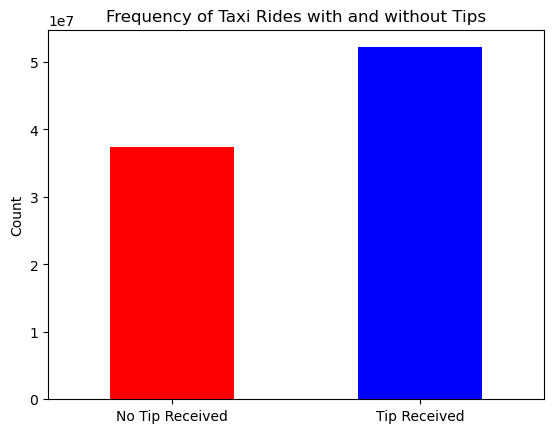

In [56]:
from pyspark.sql.functions import col, when
df = df.withColumn("tips_class", when(col("tips") == 0, "tips = 0").otherwise("tips != 0"))

pandas_df = df.groupBy("tips_class").count().toPandas()

ax = pandas_df.plot(kind='bar', x='tips_class', y='count', color=["red","blue"], legend=None)

ax.set_xticklabels(['No Tip Received', 'Tip Received'])

# Graph aesthetics
plt.title('Frequency of Taxi Rides with and without Tips')
plt.ylabel('Count')
plt.xlabel('')
plt.xticks(rotation=0)  # Adjust rotation as needed

# Show plot
plt.show()

In [57]:
# Create some new features from the existing ones
from pyspark.sql.functions import when, desc


df = df.withColumn("trip_duration_hours", (col("trip_seconds") / 3600))

# Calculate average speed in miles per hour, account for when the duration of hours is 0
df = df.withColumn("average_speed_mph", when(col("trip_duration_hours") != 0, col("trip_miles") / col("trip_duration_hours")).otherwise(0))

# Calculate tips per second
df = df.withColumn("tips_per_sec", col("tips") / col("trip_seconds"))

# Convert tips per second to tips per hour
df = df.withColumn("tips_per_hour", col("tips_per_sec") * 3600)

# Calculate income difference
df = df.withColumn("income_difference", col("pickup_PER CAPITA INCOME ") - col("dropoff_PER CAPITA INCOME "))

# Calculate hardship index difference
df = df.withColumn("hardship_index_difference", col("pickup_HARDSHIP INDEX") - col("dropoff_HARDSHIP INDEX"))

# Calculate percentage differences for a specific feature
df = df.withColumn("percent_housing_crowded_diff", col("pickup_PERCENT OF HOUSING CROWDED") - col("dropoff_PERCENT OF HOUSING CROWDED"))

In [58]:
df.select("tips_per_hour").show(10)

+------------------+
|     tips_per_hour|
+------------------+
|               0.0|
|16.799999999999997|
|               0.0|
|               0.0|
| 8.333333333333332|
|               0.0|
|              20.0|
|              null|
|               0.0|
|10.909090909090908|
+------------------+
only showing top 10 rows



In [59]:
from pyspark.sql.functions import regexp_replace
from pyspark.sql.types import IntegerType, FloatType
# Convert all of this stuff to numbers instead of strings

for column in df.columns:
    if "PERCENT" in column or "INCOME" in column or "HARDSHIP INDEX" in column:
        df = df.withColumn(column, regexp_replace(column, "[^0-9.]", "").cast(FloatType()))

Create a pickup and dropoff relationship chart

In [60]:
top_pickup_locations = df.groupBy("pickup_COMMUNITY AREA NAME").count().orderBy(desc("count")).limit(5)

top_dropoff_locations = df.groupBy("dropoff_COMMUNITY AREA NAME").count().orderBy(desc("count")).limit(5)

filtered_trips = df.join(top_pickup_locations, "pickup_COMMUNITY AREA NAME").join(top_dropoff_locations, "dropoff_COMMUNITY AREA NAME")

trip_counts = filtered_trips.groupBy("pickup_COMMUNITY AREA NAME", "dropoff_COMMUNITY AREA NAME").count()

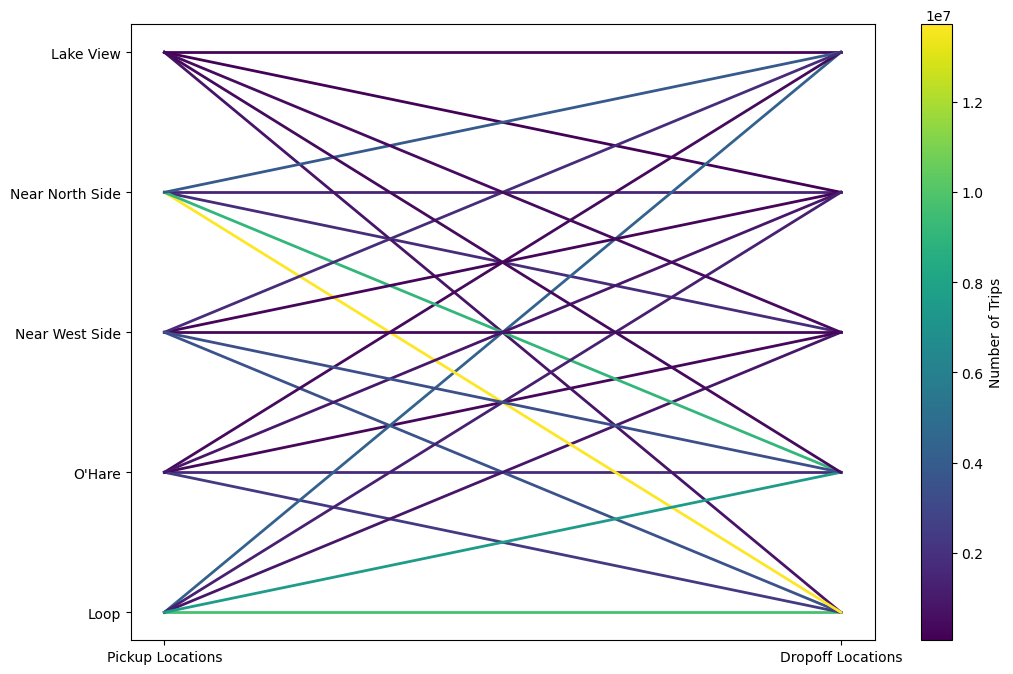

In [61]:
trip_counts_pd = trip_counts.toPandas()

fig, ax = plt.subplots(figsize=(12, 8))

pickup_locations = trip_counts_pd['pickup_COMMUNITY AREA NAME'].unique()
dropoff_locations = trip_counts_pd['dropoff_COMMUNITY AREA NAME'].unique()

for _, row in trip_counts_pd.iterrows():
    pickup_idx = list(pickup_locations).index(row['pickup_COMMUNITY AREA NAME'])
    dropoff_idx = list(dropoff_locations).index(row['dropoff_COMMUNITY AREA NAME'])
    ax.plot([1, 2], [pickup_idx, dropoff_idx], color=plt.cm.viridis(row['count']/trip_counts_pd['count'].max()), lw=2)

ax.set_xticks([1, 2])
ax.set_xticklabels(['Pickup Locations', 'Dropoff Locations'])
ax.set_yticks(range(len(pickup_locations)))
ax.set_yticklabels(pickup_locations)
ax.set_yticks(range(len(dropoff_locations)), minor=True)
ax.set_yticklabels(dropoff_locations, minor=True)

sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=trip_counts_pd['count'].min(), vmax=trip_counts_pd['count'].max()))
cbar = plt.colorbar(sm)
cbar.set_label('Number of Trips')

plt.show()

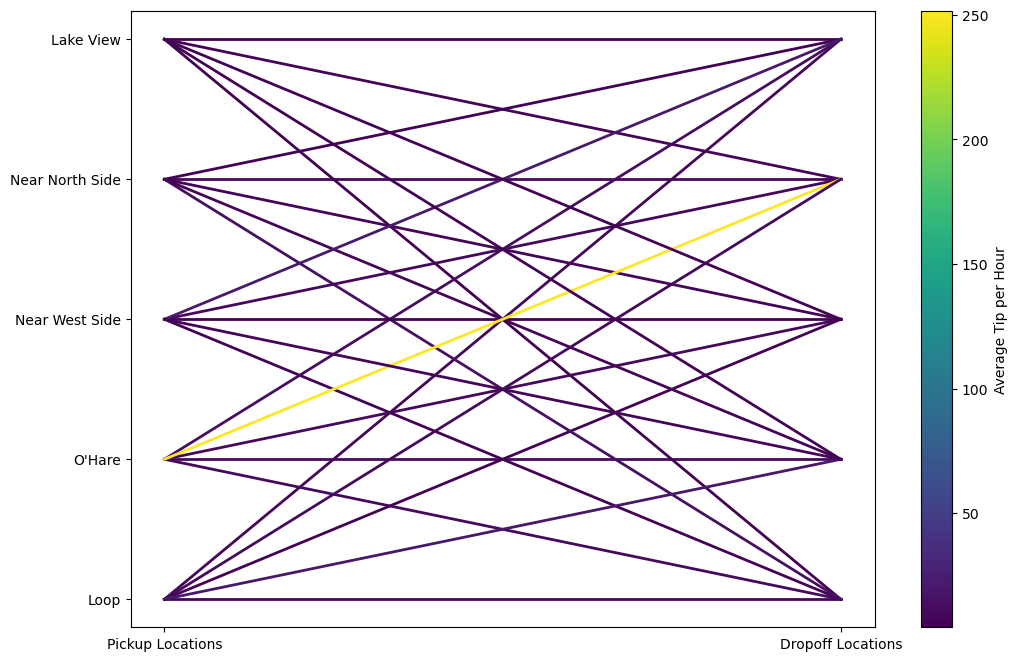

In [62]:
from pyspark.sql.functions import desc, count, avg

trip_info = df.groupBy("pickup_COMMUNITY AREA NAME", "dropoff_COMMUNITY AREA NAME") \
              .agg(count("*").alias("count"), avg("tips_per_hour").alias("avg_tip_per_hour"))

top_pickup_areas = [row["pickup_COMMUNITY AREA NAME"] for row in top_pickup_locations.collect()]
top_dropoff_areas = [row["dropoff_COMMUNITY AREA NAME"] for row in top_dropoff_locations.collect()]

filtered_trip_info = trip_info.filter(
    trip_info["pickup_COMMUNITY AREA NAME"].isin(top_pickup_areas) & 
    trip_info["dropoff_COMMUNITY AREA NAME"].isin(top_dropoff_areas)
)

trip_info_pd = filtered_trip_info.toPandas()

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))

pickup_locations = trip_info_pd['pickup_COMMUNITY AREA NAME'].unique()
dropoff_locations = trip_info_pd['dropoff_COMMUNITY AREA NAME'].unique()

for _, row in trip_info_pd.iterrows():
    pickup_idx = list(pickup_locations).index(row['pickup_COMMUNITY AREA NAME'])
    dropoff_idx = list(dropoff_locations).index(row['dropoff_COMMUNITY AREA NAME'])
    norm_tip = (row['avg_tip_per_hour'] - trip_info_pd['avg_tip_per_hour'].min()) / (trip_info_pd['avg_tip_per_hour'].max() - trip_info_pd['avg_tip_per_hour'].min())
    ax.plot([1, 2], [pickup_idx, dropoff_idx], color=plt.cm.viridis(norm_tip), lw=2)

ax.set_xticks([1, 2])
ax.set_xticklabels(['Pickup Locations', 'Dropoff Locations'])
ax.set_yticks(range(len(pickup_locations)))
ax.set_yticklabels(pickup_locations)
ax.set_yticks(range(len(dropoff_locations)), minor=True)
ax.set_yticklabels(dropoff_locations, minor=True)

sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=trip_info_pd['avg_tip_per_hour'].min(), vmax=trip_info_pd['avg_tip_per_hour'].max()))
cbar = plt.colorbar(sm)
cbar.set_label('Average Tip per Hour')

plt.show()

In [63]:
from pyspark.sql import functions as F
import pandas as pd
import matplotlib.pyplot as plt

grouped_data = df.groupBy("pickup_COMMUNITY AREA NAME").agg(F.mean("tips_per_hour").alias("avg_tips_per_hour"))

pandas_df = grouped_data.orderBy(desc("avg_tips_per_hour")).limit(20).toPandas()

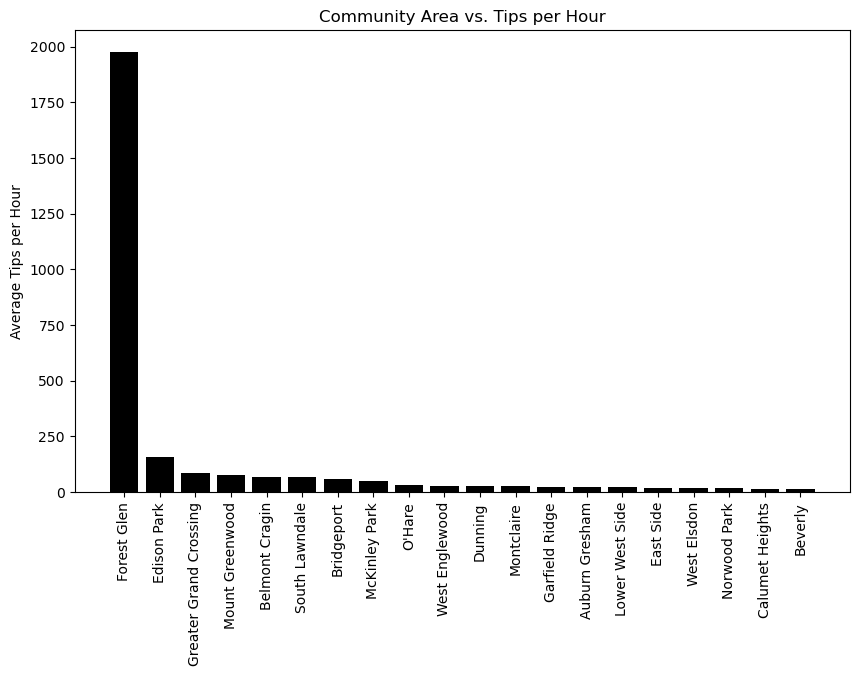

In [64]:
plt.figure(figsize=(10, 6))
plt.bar(pandas_df['pickup_COMMUNITY AREA NAME'], pandas_df['avg_tips_per_hour'], color='black')
plt.title('Community Area vs. Tips per Hour')
plt.xlabel('')
plt.ylabel('Average Tips per Hour')
plt.xticks(rotation=90)  # Rotating x-axis labels
plt.show()

# Modeling Part

In [65]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.types import IntegerType, FloatType, DoubleType

def get_numeric_columns(df):
    numeric_col_types = (IntegerType, FloatType, DoubleType)
    return [field.name for field in df.schema.fields if isinstance(field.dataType, numeric_col_types)]

numeric_columns = get_numeric_columns(df)
numeric_columns = [col for col in numeric_columns if "tips" not in col]
numeric_columns = [col for col in numeric_columns if col != "trip_total"]


# String Indexer
string_indexer = StringIndexer(inputCol="pickup_COMMUNITY AREA NAME", outputCol="pickup_COMMUNITY AREA NAME_index")

# One-Hot Encoder
one_hot_encoder = OneHotEncoder(inputCol="pickup_COMMUNITY AREA NAME_index", outputCol="pickup_COMMUNITY AREA NAME_vec")

assembler = VectorAssembler(inputCols=[*numeric_columns, "pickup_COMMUNITY AREA NAME_vec"], outputCol="features")

# Pipeline
pipeline = Pipeline(stages=[string_indexer, one_hot_encoder, assembler])

# Fit
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)
pipeline_model = pipeline.fit(train_data)
train_data = pipeline_model.transform(train_data)
test_data = pipeline_model.transform(test_data)

In [ ]:
print(train_data.count())
print(test_data.count())
train_data = train_data.dropna().repartition(160)
test_data = test_data.dropna().repartition(160)  # Sometimes the train encoding or string indexer introduces some null values
# In addition, there was also some nulls introduced when trip_duration is 0, so it is good we remove those rows as well
# because 0 duration trips likely represent errors in data creation
print(train_data.count())
print(test_data.count())

71669683


17923710


70294267


In [ ]:
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor, DecisionTreeRegressor
from pyspark.ml import Pipeline

models = {
   "LinearRegression": LinearRegression(featuresCol="features", regParam=0.01, labelCol="tips_per_hour"),
    "RandomForestRegressor": RandomForestRegressor(featuresCol="features", labelCol="tips_per_hour"),
    "GBTRegressor": GBTRegressor(featuresCol="features", labelCol="tips_per_hour"),
}


evaluator = RegressionEvaluator(labelCol="tips_per_hour", predictionCol="prediction", metricName="rmse")


for name, model in models.items():

    # Fit model
    fitted_model = model.fit(train_data)

    # Make predictions
    predictions = fitted_model.transform(test_data)

    # Evaluate predictions
    rmse = evaluator.evaluate(predictions)
    print(f"{name}: RMSE = {rmse}")


23/11/29 18:54:15 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/11/29 18:54:15 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
23/11/29 18:54:15 WARN com.github.fommil.netlib.LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
23/11/29 18:54:15 WARN com.github.fommil.netlib.LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


LinearRegression: RMSE = 230.6981194818336


RandomForestRegressor: RMSE = 201.22755068867644


23/11/29 19:15:24 WARN org.apache.spark.deploy.yarn.YarnAllocator: Container from a bad node: container_1701270945045_0004_01_000002 on host: hub-msca-bdp-dphub-students-zfarahany-sw-30lw.c.msca-bdp-student-ap.internal. Exit status: 143. Diagnostics: [2023-11-29 19:15:24.527]Container killed on request. Exit code is 143
[2023-11-29 19:15:24.527]Container exited with a non-zero exit code 143. 
[2023-11-29 19:15:24.532]Killed by external signal
.
23/11/29 19:15:24 WARN org.apache.spark.scheduler.cluster.YarnSchedulerBackend$YarnSchedulerEndpoint: Requesting driver to remove executor 2 for reason Container from a bad node: container_1701270945045_0004_01_000002 on host: hub-msca-bdp-dphub-students-zfarahany-sw-30lw.c.msca-bdp-student-ap.internal. Exit status: 143. Diagnostics: [2023-11-29 19:15:24.527]Container killed on request. Exit code is 143
[2023-11-29 19:15:24.527]Container exited with a non-zero exit code 143. 
[2023-11-29 19:15:24.532]Killed by external signal
.
23/11/29 19:15:24

GBTRegressor: RMSE = 195.8573827963292


In [ ]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import GBTRegressor
import numpy as np
# Probably do not re-run this cell as it might take a really long time


gbt = GBTRegressor(featuresCol="features", labelCol="tips_per_hour")

# Define hyperparams
all_maxDepths = np.arange(2, 10)  # Range for maxDepth
all_maxIters = np.arange(10, 50, 10)  # Range for maxIter

maxDepths = np.random.choice(all_maxDepths, size=2, replace=False)
maxIters = np.random.choice(all_maxIters, size=2, replace=False)

paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, maxDepths)
             .addGrid(gbt.maxIter, maxIters)
             .build())

evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="tips_per_hour", metricName="rmse")

cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)

cvModel = cv.fit(train_data)

bestModel = cvModel.bestModel

predictions = bestModel.transform(test_data)

rmse = evaluator.evaluate(predictions)
print("Best RMSE: ", rmse)


In [ ]:
# Retrain the best model
evaluator = RegressionEvaluator(labelCol="tips_per_hour", predictionCol="prediction", metricName="rmse")
model = GBTRegressor(featuresCol="features", labelCol="tips_per_hour", maxDepth = 6, maxIter = 50)
fitted_model = model.fit(train_data)
predictions = fitted_model.transform(test_data)
rmse = evaluator.evaluate(predictions)
print(f"RMSE = {rmse}")

RMSE = 194.07522192000545


In [35]:
# Get the feature importance names
stages = pipeline_model.stages

string_indexer_model = stages[0]
category_names = string_indexer_model.labels

one_hot_feature_names = [f"{string_indexer.getInputCol()}_{category}" for category in category_names]

all_feature_names = numeric_columns + one_hot_feature_names

importances = fitted_model.featureImportances.toArray()

# Map feature names to their importances
feature_importance_dict = dict(zip(all_feature_names, importances))

In [36]:
# Show the feature importances
sorted_dict = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse = True))
sorted_dict

{'fare': 0.3235489761519567,
 'trip_duration_hours': 0.2749794160068111,
 'trip_miles': 0.09927538666356506,
 'average_speed_mph': 0.0957216016519484,
 'extras': 0.045445468651743544,
 'percent_housing_crowded_diff': 0.01648082268578219,
 'pickup_longitude': 0.0161846247862368,
 'hardship_index_difference': 0.015588067750055279,
 'dropoff_longitude': 0.01509295752821614,
 'dropoff_PERCENT AGED UNDER 18 OR OVER 64': 0.014657611287563356,
 'dropoff_latitude': 0.014435258313178791,
 'pickup_latitude': 0.013455160883487575,
 'income_difference': 0.008424196049529783,
 'dropoff_PERCENT OF HOUSING CROWDED': 0.006661907825328126,
 'dropoff_PER CAPITA INCOME ': 0.005723824310797676,
 'pickup_PERCENT OF HOUSING CROWDED': 0.005352569087534396,
 'dropoff_PERCENT HOUSEHOLDS BELOW POVERTY': 0.0046085158213083925,
 'pickup_PERCENT AGED 16+ UNEMPLOYED': 0.0037986143029843863,
 'pickup_HARDSHIP INDEX': 0.0025490549661338993,
 'pickup_COMMUNITY AREA NAME_Garfield Ridge': 0.002368362603765087,
 'pickup_

In [41]:
# This shows us there is a negative relationship between tips per hour and duration
from pyspark.sql.functions import corr

df.select(corr("trip_duration_hours", "tips_per_hour")).collect()[0][0]

-0.01566404970518931

In [42]:
# This shows us there is a negative relationship between tips per hour and duration
from pyspark.sql.functions import corr

df.select(corr("hardship_index_difference", "tips_per_hour")).collect()[0][0]

0.0013082788022911792

In [ ]:
# The relationship between duration and tips is shown on David's notebook and is intuitive due to the inverse relationship
# between duration and tips per hour